In [2]:
%matplotlib inline

import re
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

sns.set(style='darkgrid')

**Корпус новостей от Yandex**

In [3]:
new_columns_name = {'ID СОБЫТИЯ':'hr_level_3', 'ВРЕМЯ ПУБЛИКАЦИИ':'time', 'НОВОСТНОЕ ИЗДАНИЕ':'publication',  
                    'РУБРИКА':'hr_level_0', 'ПОДРУБРИКА':'hr_level_1', 
                    'ЗАГОЛОВОК СТАТЬИ':'title', 'СНИППЕТ':'snippet', 'ТЕКСТ':'text'}

articles = pd.read_csv('../data/raw/articles.csv', sep=';')
articles = articles.dropna().drop('URL', axis=1)
articles = articles.rename(index=str, columns=new_columns_name)

articles.head()

,hr_level_3,hr_level_0,hr_level_1,publication,time,title,snippet,text
0,100-1522358182477262,Авто,Авто,Версия.Инфо,2018-03-29T16:36:00,Представлен ТОП-10 вторичных авторынков России...,"Эксперты отмечают, что резкий скачок продаж по...",Аналитики агентства «АВТОСТАТ» представили ТОП...
1,100-1522358232202121,Авто,Авто,Финмаркет,2018-03-29T14:13:00,В этом году на льготные автокредиты и лизинг б...,FINMARKET.RU - Премьер России Дмитрий Медведев...,В этом году на льготные автокредиты и лизинг б...
2,100-1522358232202121,Авто,Авто,ТАСС,2018-03-29T14:16:00,Медведев: около 50 тыс. машин продадут в 2018 ...,Около 50 тыс. автомашин будет продано в текуще...,Около 50 тыс. автомашин будет продано в текуще...
3,100-1522358232202121,Авто,Авто,Российская газета,2018-03-29T14:30:00,Кабмин выделит 7 миллиардов рублей на льготное...,Правительство выделяет 7 миллиардов рублей на ...,Названы ставки по ипотеке и автокредитам в 201...
4,100-1522358232202121,Авто,Авто,Телеканал 360°,2018-03-29T14:43:00,Правительство РФ выделит порядка 7 млрд на льг...,Из указанной суммы около семи миллиардов напра...,Правительством России предусмотрено свыше 12 м...


In [3]:
print(f'Новостной корпус содержит {len(articles)} статьи, которые разбиты на {len(articles.hr_level_3.unique())} темы нижнего уровня.')

Новостной корпус содержит 14414 статьи, которые разбиты на 3239 темы нижнего уровня.


In [4]:
clean_space = lambda x: re.sub('\s+', ' ', x)

articles.title = articles.title.apply(clean_space)
articles.text = articles.text.apply(clean_space)

**Доля букв кирилического алфавита в новостных статьях**

In [5]:
def count_cyrillic_characters(text):
    
    text = text.replace(' ', '').lower()
    return len(re.findall('[а-я]', text))/len(text)

cyrillic_characters_counts = articles.text.apply(count_cyrillic_characters)
print('Темы содержат от {} до {} букв кириллического алфавита'.format(min(cyrillic_characters_counts), max(cyrillic_characters_counts)))

Темы содержат от 0.1231572958154451 до 0.9948979591836735 букв кириллического алфавита


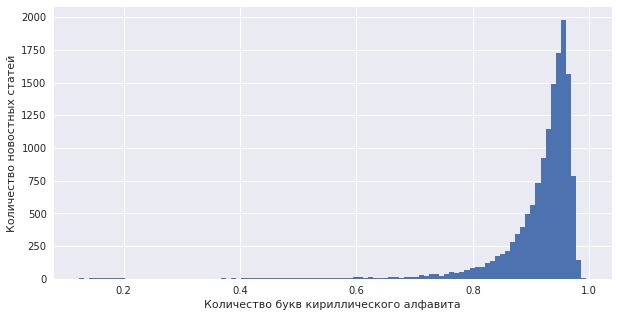

In [6]:
hist = cyrillic_characters_counts.plot.hist(figsize=(10, 5), bins=100)
hist.set(xlabel='Количество букв кириллического алфавита', ylabel='Количество новостных статей')

plt.show()

По графику видно, что часть новостных статей, содержит небольшую долю кириллических букв - это может сведельствовать о том, что статьи перенасыщены числовыми показателями (например, сводки курсов валют) или содержат много мусора (например, часть кода разметки страницы).

Далее будем работать только со статьями содержащими неменее 0.8 кириллических букв.

In [7]:
articles = articles[cyrillic_characters_counts >= 0.8]
print(f'Новостной корпус содержит {len(articles)} статьи, которые разбиты на {len(articles.hr_level_3.unique())} темы.')

Новостной корпус содержит 13631 статьи, которые разбиты на 3193 темы.


**Количество новостных статей в темах**

In [8]:
topics_counts = articles.groupby('id').id.count()
print(f'Темы содержат от {min(topics_counts)} до {max(topics_counts)} статей')

Темы содержат от 1 до 70 статей


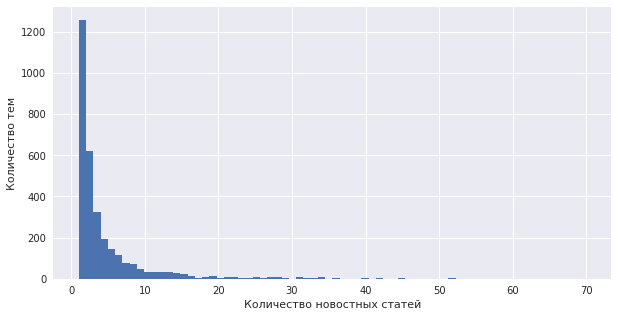

In [9]:
hist = topics_counts.plot.hist(figsize=(10, 5), bins=70)
hist.set(xlabel='Количество новостных статей', ylabel='Количество тем')

plt.show()

In [10]:
articles = articles[articles.hr_level_3.isin(topics_counts[topics_counts >= 3].index)]
print(f'Новостной корпус содержит {len(articles)} статьи, которые разбиты на {len(articles.hr_level_3.unique())} темы.')

Новостной корпус содержит 11127 статьи, которые разбиты на 1312 темы.


In [11]:
articles.loc[:, 'id'] = LabelEncoder().fit_transform(articles.hr_level_3)

articles['hr_level_2'] = np.nan
articles['hr_level_4'] = np.nan

articles = articles[['id', 'hr_level_0', 'hr_level_1', 'hr_level_2', 'hr_level_3', 'hr_level_4', 
                     'publication', 'time', 'title', 'snippet', 'text']]

articles.to_csv('../data/interim/articles.csv', index=False)